<a href="https://colab.research.google.com/github/jordankando/brillouinfitting/blob/main/6_Burnman3_Elasticity_exercise_corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run this to install packages if in Colab!

In [45]:
#!pip install burnman==1.2.0 numpy==1.24.4
#!pip install --force-reinstall numpy==1.24.4

In [46]:
# import burnman packages, particularly the anisotropy module.
import burnman
from burnman.classes import anisotropy

In [47]:
# first import necessary modules
from __future__ import print_function

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
# import the module for matrix rotation

from pyquaternion import Quaternion

In [49]:
# define the styles for the plot
try:
    plt.style.use('ggplot')
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['figure.figsize'] = 16, 10 # inches
except:
    pass

# Project  Portion:


## Main Project Functions

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


import burnman.utils.unitcell
import scipy.optimize


See https://orix.readthedocs.io/en/stable/tutorials/crystal_reference_frame.html for reference for below calculation.


In [51]:
# TODO: Convert Miller indices to cartesian vector, and vice versa
# recall Miller Index to Cartesian Coordinate is equal to the inversion of the
# (h k l) = (1/x , 1/y, 1/z) ; (1 0 0) is (1, inf, inf); (2 1 0) is (1/2, 1, inf)
def convert_miller_to_cartesian(hkl, unit_cell_params):
  A = burnman.utils.unitcell.cell_parameters_to_vectors(unit_cell_params)
  xyz = hkl @ np.linalg.inv(A).T
  return xyz

def convert_cartesian_to_miller(xyz, unit_cell_params):
  [a, b, c, alpha, beta, gamma] = unit_cell_params
  A = burnman.utils.unitcell.cell_parameters_to_vectors(unit_cell_params)

  hkl = xyz @ np.linalg.inv(np.linalg.inv(A).T)
  return hkl



In [52]:
def compute_anisotropic_params(mineral,
                              angle_range,
                              angle_count,
                              plane_normal,
                              direction,
                              offset = 0):

  direction_prime = []
  angle = []

  angles = np.linspace(offset, offset+angle_range, angle_count)

  direction_prime = []
  angle = []

  for a in angles:
    q = Quaternion(axis = plane_normal, degrees = a)
    d_prime = q.rotate(direction)
    direction_prime.append(d_prime)
    angle.append(q.degrees)

  vps = []
  vs1s = []
  vs2s = []
  betas = []
  Es = []
  #incident_angle = np.empty_like(direction_prime)

  for i, d in enumerate(direction_prime):
      velocities = mineral.wave_velocities(d)
      betas.append(mineral.isentropic_linear_compressibility(d))
      Es.append(mineral.isentropic_youngs_modulus(d))
      vps.append(velocities[0][0])
      vs1s.append(velocities[0][1])
      vs2s.append(velocities[0][2])

  return (vps, vs1s, vs2s, betas, Es)

In [53]:
# Same as above, but velocities only
def compute_anisotropic_vel(mineral,
                            angle_range,
                            angle_count,
                            plane_normal,
                            direction,
                            offset = 0):

  angles = np.linspace(offset, offset+angle_range, angle_count)

  direction_prime = []
  angle = []

  for a in angles:
    q = Quaternion(axis = plane_normal, degrees = a)
    d_prime = q.rotate(direction)
    direction_prime.append(d_prime)
    angle.append(q.degrees)

  vps = []
  vs1s = []
  vs2s = []
  betas = []
  Es = []
  #incident_angle = np.empty_like(direction_prime)

  for i, d in enumerate(direction_prime):
      velocities = mineral.wave_velocities(d)
      vps.append(velocities[0][0])
      vs1s.append(velocities[0][1])
      vs2s.append(velocities[0][2])

  return (vps, vs1s, vs2s)

In [54]:
def fit_Cij_lsq(xs,
            ys,
            theta_0,
            mineral_type,
            rho,
            hkl_norm,
            unit_cell_params):

  """Primary least squares fitting function:

  Args:

  xs: (1xn) Measurement angles in degrees (nd.array)
  ys: (3xn) M output parameters (vp, vs1, vs2)  (nd.array):
  theta0: Initial guesses on Cijs, offset angle
  mineral_type: Mineral defining function from burnman (default: burnman.anisotropy.CubicMaterial)
  rho: density in units?
  hkl_norm: Miller indices of plane normal
  unit_cell_params: a, b, c, alpha, beta, gamma that define a particular unit cell
  """

  ys_flat = np.array(ys)
  ys_flat = ys.flatten()

  # Convert plane hkl to Cartesian vector of plane normal
  plane_normal = convert_miller_to_cartesian(hkl=hkl_norm,
                                             unit_cell_params = unit_cell_params)

  # Determine starting vector orthogonal to plane normal

  # Handle edge case where if starting vector is [0,0,1],
  # then would return [0,0,0] as vector
  if plane_normal[0] == 0.0 and plane_normal[1] == 0.0:
        direction = [1,0,0]
  else:
        direction = np.array([-plane_normal[1], plane_normal[0], 0])
        direction = direction / np.linalg.norm(direction) # Normalize dir vector

  #Determine angle range to compute over
  angle_range = np.max(xs) - np.min(xs)
  angle_count = xs.size

  #Define objective function for least squares optimization
  def obj_fun(params,
               ys = ys_flat,
               mineral_type = mineral_type,
               angle_range = angle_range,
               angle_count = angle_count,
               direction = direction,
               plane_normal = plane_normal):

    #All non-offset parameters are some number of Cij
    offset = params[-1]
    Cijs = params[:-1]

    #Define mineral using burnman.anisotropy mineral class for given Cijs
    mineral = mineral_type(rho, Cijs)

    #Compute anisotropic parameters
    (vps, vs1s, vs2s) = compute_anisotropic_vel(mineral = mineral,
                                                angle_range = angle_range,
                                                angle_count = angle_count, #due to included endpoints
                                                plane_normal = plane_normal,
                                                direction = direction,
                                                offset = offset)
    #Consolidate multiple properties of material
    ymodel = np.array(vps + vs1s + vs2s)

    #Return differnce between modeled and observed properties
    return ymodel - ys

  # No bounds on Cij
  low_bound = np.ones_like(theta_0[:-1]) * -np.inf
  high_bound = -low_bound

  # Offset bound between -180 and 180 deg for symmetry
  low_bound = low_bound.tolist() + [-180.]
  high_bound = high_bound.tolist() + [180.]


  # Use sci-py to perform simple non-linear least squares fitting
  result = scipy.optimize.least_squares(fun = obj_fun,
                                          x0 = theta_0,
                                          bounds = (low_bound, high_bound),
                                          verbose = 1,
                                          max_nfev=1e15,
                                          ftol = 1e-12,
                                          gtol = 1e-12)

  print(result.x)

  # Compute full curve for best fit model
  min_model = mineral_type(rho, result.x[:-1])
  best_fit_model = compute_anisotropic_vel(mineral = min_model,
                                          angle_range = 360,
                                          angle_count = 360,
                                          plane_normal = plane_normal,
                                          direction = direction,
                                          offset = result.x[-1])

  plt.figure()

  return result.x


In [55]:
def fit_Cij_(xs,
            ys,
            theta_0,
            mineral_type,
            rho,
            hkl_norm,
            unit_cell_params):

  """Primary least squares fitting function:

  Args:

  xs: (1xn) Measurement angles in degrees (nd.array)
  ys: (3xn) M output parameters (vp, vs1, vs2)  (nd.array):
  theta0: Initial guesses on Cijs, offset angle
  mineral_type: Mineral defining function from burnman (default: burnman.anisotropy.CubicMaterial)
  rho: density in units?
  hkl_norm: Miller indices of plane normal
  unit_cell_params: a, b, c, alpha, beta, gamma that define a particular unit cell
  """

  

  return 0

# Modeled Data Generation

In [56]:
# TODO: Generate sparse test data for testing the fitting

def generate_sparse_test_data(mineral_type, Cijs, offset, start_angle, end_angle, hkl_norm, rho, unit_cell_params, n_data = 15, noise_mean = 1, noise_sigma = 0.1, error_est = False):

  mineral = mineral_type(rho, Cijs)

  #print(dir(mineral))


  angle_range = -(start_angle - end_angle)

  plane_normal = convert_miller_to_cartesian(hkl=hkl_norm,
                                             unit_cell_params = unit_cell_params)

  angles = np.linspace(start_angle, end_angle, n_data)

  # Handle edge case where if starting vector is [0,0,1],
  # then would return [0,0,0] as vector
  if plane_normal[0] == 0.0 and plane_normal[1] == 0.0:
        direction = [1,0,0]
  else:
        direction = np.array([-plane_normal[1], plane_normal[0], 0])
        direction = direction / np.linalg.norm(direction) # Normalize dir vector

  #Compute anisotropic parameters
  (vps, vs1s, vs2s) = compute_anisotropic_vel(mineral = mineral,
                                              angle_range = angle_range,
                                              angle_count = n_data, #due to included endpoints
                                              plane_normal = plane_normal,
                                              direction = direction,
                                              offset = offset)

  vps = np.array(vps)
  vs1s = np.array(vs1s)
  vs2s = np.array(vs2s)

  #print(np.random.normal(noise_mean, noise_sigma))

  vps += np.random.normal(noise_mean, noise_sigma, len(vps))
  vs1s += np.random.normal(noise_mean, noise_sigma,len(vps))
  vs2s += np.random.normal(noise_mean, noise_sigma,len(vps))

  if error_est:
      vps_err *= 0.1
      vs1s_err *= 0.1
      vs2s_err *= 0.1

      return angles, vps, vs1s, vs2s, vps_err, vs1s_err, vs2s_err


  return angles, vps, vs1s, vs2s

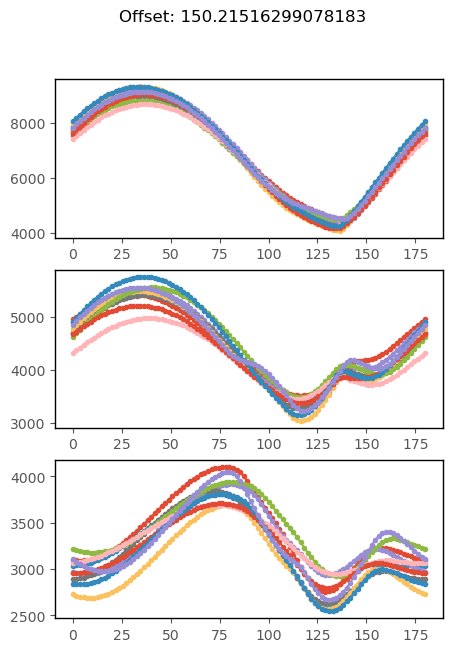

/Users/jordanando/opt/anaconda3/envs/minphys/lib/python3.11/site-packages/burnman/classes/anisotropy.py:279: RuntimeWarning: invalid value encountered in sqrt
  velocities = np.sqrt(eigenvalues / self.density)


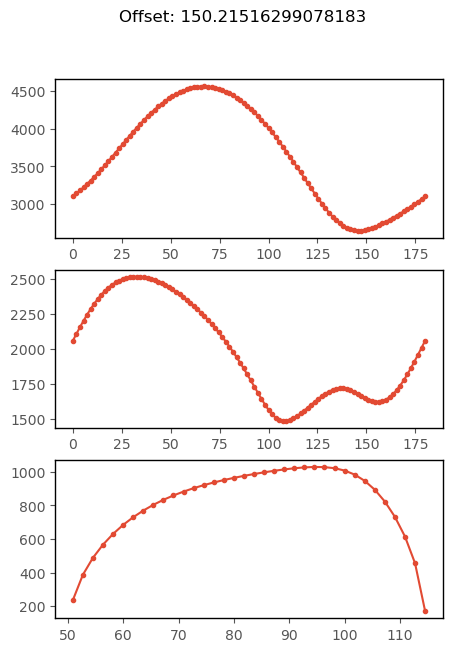

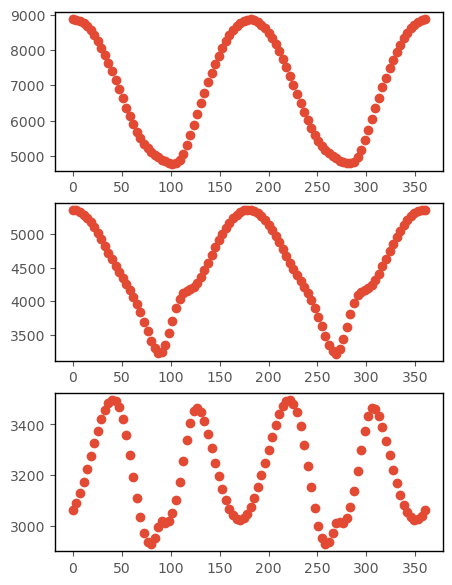

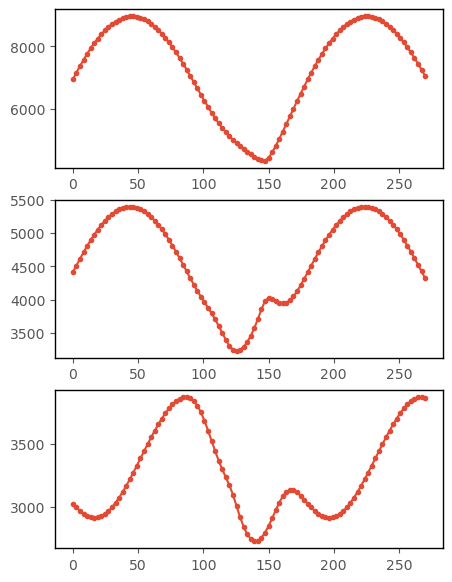

In [57]:
talc_stiffness = [219.83e9,  59.66e9,  -4.82e9,  -0.82e9, -33.87e9, -1.04e9,
                  216.38e9, -3.67e9,   1.79e9, -16.51e9,  -0.62e9,
                  48.89e9,    4.12e9, -15.52e9,  -3.59e9,
                  26.54e9,    -3.6e9,  -6.41e9,
                  22.85e9,   -1.67e9,
                  78.29e9] # Cij in Pa
rho = 2.75e3 # kg/m^3

talc_stiffness = np.array(talc_stiffness)
offset = np.random.rand() * 360
fig, ax = plt.subplots(3, 1, figsize = (5,7))

for i in range(10):
    angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = talc_stiffness * np.random.uniform(0.8, 1.2, talc_stiffness.shape),
                                                    offset = offset,
                                                    start_angle = 0.,
                                                    end_angle = 180,
                                                    hkl_norm = np.array([1,1,0]),
                                                    unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                                    rho = rho,
                                                    n_data = 100,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)



    ax[0].plot(angles, vps, '.-')
    ax[1].plot(angles, vs1s, '.-')
    ax[2].plot(angles, vs2s, '.-')
    plt.suptitle("Offset: " + str(offset))

plt.show()

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = talc_stiffness/np.abs(talc_stiffness) * 10e9,
                                                    offset = offset,
                                                    start_angle = 0.,
                                                    end_angle = 180,
                                                    hkl_norm = np.array([1,1,0]),
                                                    unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                                    rho = rho,
                                                    n_data = 100,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-')
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
plt.suptitle("Offset: " + str(offset))
plt.show()

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                            Cijs = talc_stiffness,
                                            offset = 0,
                                            start_angle = 0.,
                                            end_angle = 360,
                                            hkl_norm = np.array([1,0,0]),
                                            unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                            rho = rho,
                                            n_data = 100,
                                            noise_mean = 0,
                                            noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, 'o')
ax[1].plot(angles, vs1s, 'o')
ax[2].plot(angles, vs2s, 'o')
plt.show()

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                            Cijs = talc_stiffness,
                                            offset = np.random.rand() * 360,
                                            start_angle = 0.,
                                            end_angle = 270,
                                            hkl_norm = np.array([1,1,0]),
                                            unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09],
                                            rho = rho,
                                            n_data = 100,
                                            noise_mean = 0,
                                            noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-')
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
plt.show()

# Least squares fitting

## Triclinic Material (Talc)

In [58]:
import scipy.signal

max angle in data:  155.76923076923077
max angle in starting guess:  [ 23.78378378 203.78378378]
Early offset guess:  48.01455301455303


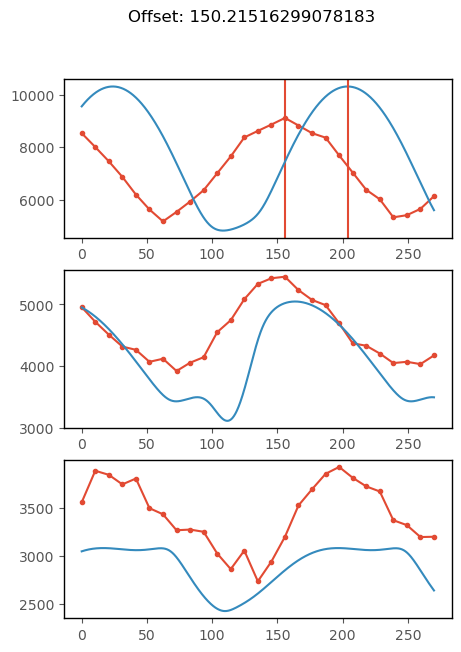

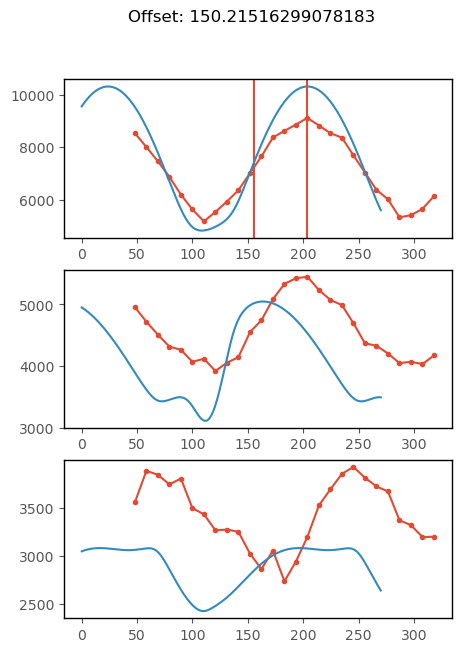

In [59]:

hkl_norm = np.array([1,2,1])
offset_true = 35
unit_cell_params = [5.290, 9.173, 9.460, 90.46, 98.68, 90.09]
rho = 2.75e3 # kg/m^3

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = talc_stiffness,
                                                    offset = offset_true,
                                                    start_angle = 0.,
                                                    end_angle = 270,
                                                    hkl_norm = hkl_norm,
                                                    unit_cell_params = unit_cell_params,
                                                    rho = rho,
                                                    n_data = 27,
                                                    noise_mean = 0,
                                                    noise_sigma = 1e2)


vs_stack = np.vstack([vps, vs1s, vs2s])

Cij_0 = talc_stiffness * np.random.uniform(0.1, 1.9, talc_stiffness.shape)

#Calculate offset
angles_o, vps_o, vs1s_o, vs2s_o = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = Cij_0,
                                                    offset = 0,
                                                    start_angle = 0.,
                                                    end_angle = 270,
                                                    hkl_norm = hkl_norm,
                                                    unit_cell_params = unit_cell_params,
                                                    rho = rho,
                                                    n_data = 1000,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)

max_angle_o = angles_o[scipy.signal.find_peaks(vps_o)[0]]
max_angle_data = angles[np.argmax(vps)]

#angle maximum in model = angle maximum in lab data - offset

offset_x = max_angle_data - max_angle_o
offset_x_idx = np.argmin(np.abs(offset_x))
offset_x = np.min(np.abs(offset_x))

print("max angle in data: ", max_angle_data)
print("max angle in starting guess: ", max_angle_o)
print("Early offset guess: ", offset_x)

fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-')
ax[0].axvline(max_angle_data)
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_o, vps_o, '-')
ax[0].axvline(max_angle_o[offset_x_idx])
ax[1].plot(angles_o, vs1s_o, '-')
ax[2].plot(angles_o, vs2s_o, '-')
plt.suptitle("Offset: " + str(offset))
plt.show()

fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles+offset_x, vps, '.-')
ax[0].axvline(max_angle_data)
ax[1].plot(angles+offset_x, vs1s, '.-')
ax[2].plot(angles+offset_x, vs2s, '.-')
ax[0].plot(angles_o, vps_o, '-')
ax[0].axvline(max_angle_o[offset_x_idx])
ax[1].plot(angles_o, vs1s_o, '-')
ax[2].plot(angles_o, vs2s_o, '-')
plt.suptitle("Offset: " + str(offset))
plt.show()



In [60]:
fit_result = fit_Cij_lsq(xs = angles,
                     ys = vs_stack,
                     theta_0 = np.append(Cij_0, offset_x),
                     mineral_type = anisotropy.TriclinicMaterial,
                     rho = rho,
                     hkl_norm=hkl_norm,
                     unit_cell_params=unit_cell_params
                     )

Cij_fit = fit_result[:-1]

`xtol` termination condition is satisfied.
Function evaluations 43, initial cost 2.3527e+07, final cost 2.3795e+05, first-order optimality 3.77e-01.
[ 2.71075198e+11  5.08539364e+10  2.54420416e+10  7.94166033e+10
  5.03541933e+10  9.08999950e+10  1.93731703e+11 -8.99689926e+09
 -9.70408772e+09 -8.14678558e+10 -7.49717152e+10  4.78666997e+10
 -3.61646395e+09 -3.08958778e+10 -2.57399642e+10  1.55643592e+10
 -1.77793026e+10 -3.65679824e+10  4.51597780e+10  3.22192881e+09
  5.57128844e+10  3.12500736e+01]


<Figure size 1600x1000 with 0 Axes>

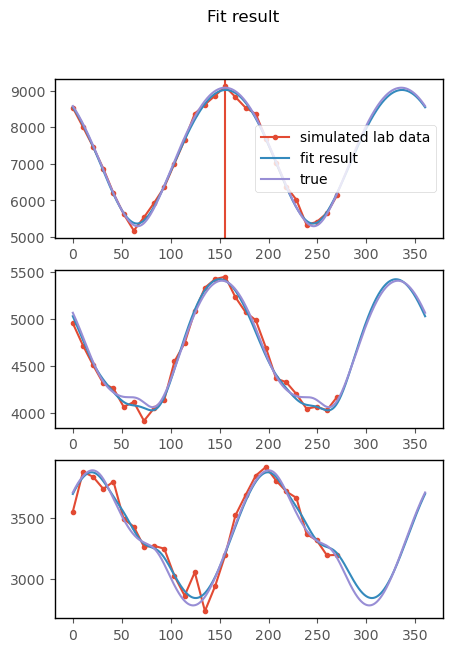

In [61]:
angles_fit, vps_fit, vs1s_fit, vs2s_fit = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = Cij_fit,
                                                    offset = fit_result[-1],
                                                    start_angle = 0.,
                                                    end_angle = 360,
                                                    hkl_norm = hkl_norm,
                                                    unit_cell_params = unit_cell_params,
                                                    rho = rho,
                                                    n_data = 1000,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)

angles_true, vps_true, vs1s_true, vs2s_true = generate_sparse_test_data(mineral_type = anisotropy.TriclinicMaterial,
                                                    Cijs = talc_stiffness,
                                                    offset = offset_true,
                                                    start_angle = 0.,
                                                    end_angle = 360,
                                                    hkl_norm = hkl_norm,
                                                    unit_cell_params = unit_cell_params,
                                                    rho = rho,
                                                    n_data = 1000,
                                                    noise_mean = 0,
                                                    noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-', label = "simulated lab data")
ax[0].axvline(max_angle_data)
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_fit, vps_fit, '-', label = "fit result")
ax[1].plot(angles_fit, vs1s_fit, '-')
ax[2].plot(angles_fit, vs2s_fit, '-')
ax[0].plot(angles_true, vps_true, '-', label = "true")
ax[1].plot(angles_true, vs1s_true, '-')
ax[2].plot(angles_true, vs2s_true, '-')
plt.suptitle("Fit result")
ax[0].legend()
plt.show()

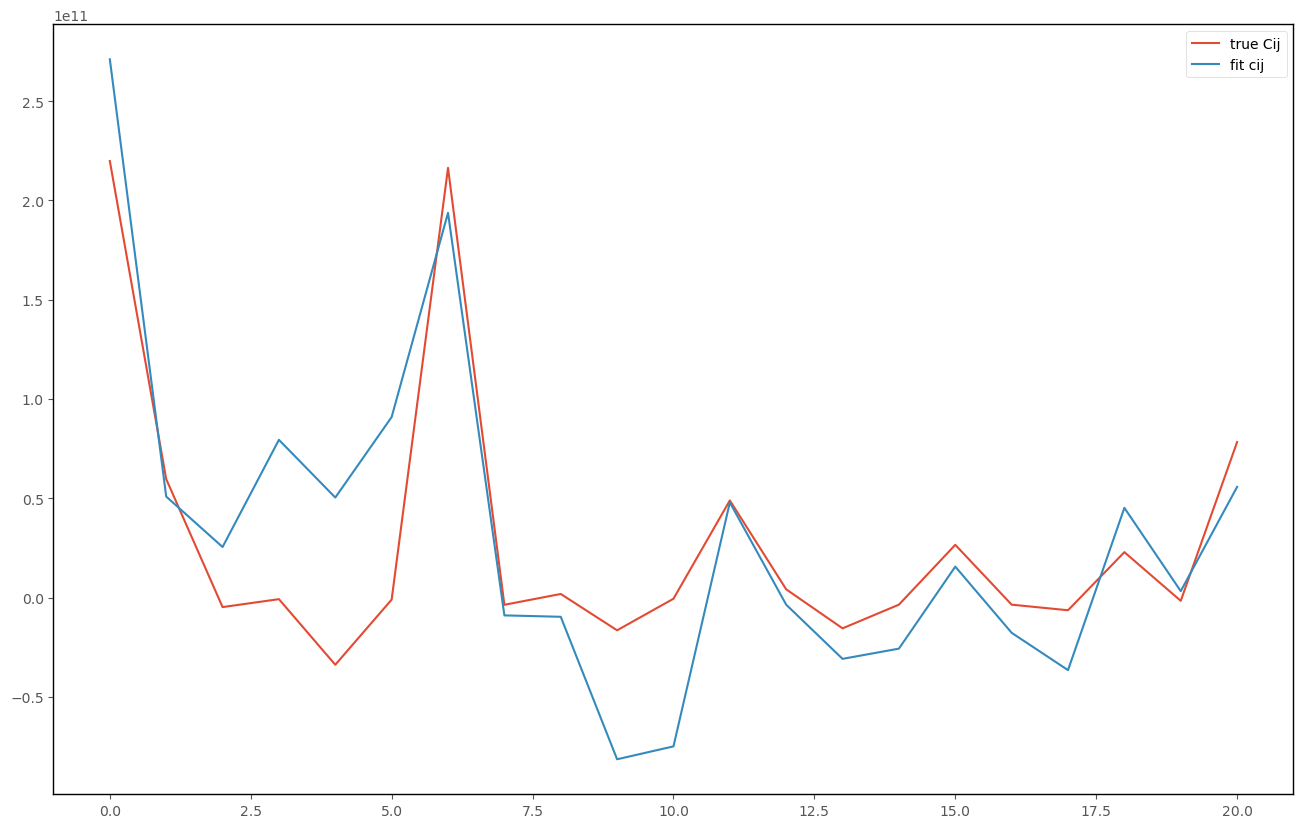

In [62]:
plt.figure()
plt.plot(talc_stiffness, label = "true Cij")
plt.plot(Cij_fit,  label = "fit cij")

plt.legend()
plt.show()

It works!

In [63]:
print(talc_stiffness)

[ 2.1983e+11  5.9660e+10 -4.8200e+09 -8.2000e+08 -3.3870e+10 -1.0400e+09
  2.1638e+11 -3.6700e+09  1.7900e+09 -1.6510e+10 -6.2000e+08  4.8890e+10
  4.1200e+09 -1.5520e+10 -3.5900e+09  2.6540e+10 -3.6000e+09 -6.4100e+09
  2.2850e+10 -1.6700e+09  7.8290e+10]


## Tetragonal Material (Shistovite)


In [64]:
stishovite_stiffness = [455e9,  199e9,  192e9,  762e9, 258e9, 321e9]
stishovite_stiffness = np.array(stishovite_stiffness)

max angle in data:  270.0
max angle in starting guess:  [ 70.81081081 149.18918919 250.81081081]
Early offset guess:  19.189189189189165


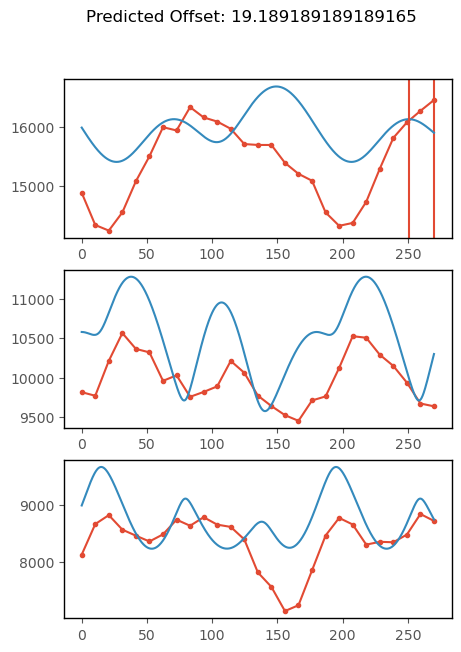

Both `ftol` and `xtol` termination conditions are satisfied.
Function evaluations 13, initial cost 2.5756e+07, final cost 4.2323e+05, first-order optimality 1.05e+02.
[4.55701350e+11 2.02763321e+11 1.94360422e+11 7.77199448e+11
 2.54807592e+11 3.25067505e+11 8.86660365e-01]


<Figure size 1600x1000 with 0 Axes>

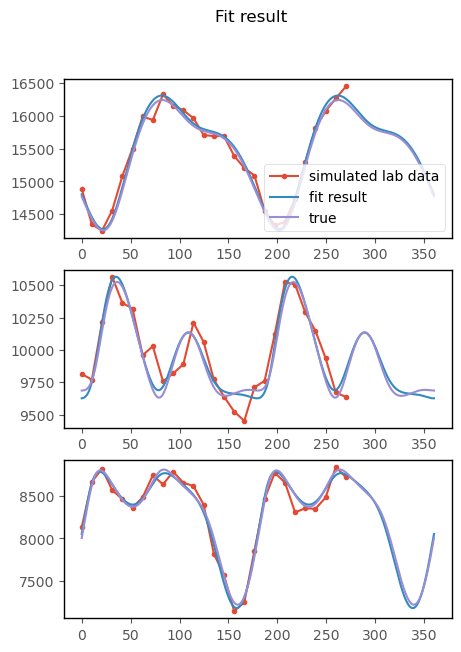

In [65]:
hkl_norm = np.array([1,2,1])
offset_true = 0
unit_cell_params = [4.1801, 4.1801, 2.6678, 90, 90, 90]
rho = 2.75e3

angles, vps, vs1s, vs2s = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true,
                                                start_angle = 0.,
                                                end_angle = 270,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 27,
                                                noise_mean = 0,
                                                noise_sigma =1e2)


vs_stack = np.vstack([vps, vs1s, vs2s])

Cij_0 = stishovite_stiffness * np.random.uniform(0.4, 1.7, stishovite_stiffness.shape)

#Calculate offset
angles_o, vps_o, vs1s_o, vs2s_o = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = Cij_0,
                                                offset = 0,
                                                start_angle = 0.,
                                                end_angle = 270,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 1000,
                                                noise_mean = 0,
                                                noise_sigma = 0)


max_angle_o = angles_o[scipy.signal.find_peaks(vps_o)[0]]
max_angle_data = angles[np.argmax(vps)]

#angle maximum in model = angle maximum in lab data - offset

offset_x = max_angle_data - max_angle_o
offset_x_idx = np.argmin(np.abs(offset_x))
offset_x = np.min(np.abs(offset_x))

print("max angle in data: ", max_angle_data)
print("max angle in starting guess: ", max_angle_o)
print("Early offset guess: ", offset_x)

fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-')
ax[0].axvline(max_angle_data)
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_o, vps_o, '-')
ax[0].axvline(max_angle_o[offset_x_idx])
ax[1].plot(angles_o, vs1s_o, '-')
ax[2].plot(angles_o, vs2s_o, '-')
plt.suptitle("Predicted Offset: " + str(offset_x))
plt.show()




fit_result = fit_Cij_lsq(xs = angles,
                    ys = vs_stack,
                    theta_0 = np.append(Cij_0, offset_x),
                    mineral_type = anisotropy.TetragonalMaterial,
                    rho = rho,
                    hkl_norm=hkl_norm,
                    unit_cell_params=unit_cell_params
                    )

Cij_fit = fit_result[:-1]

angles_fit, vps_fit, vs1s_fit, vs2s_fit = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                                    Cijs = Cij_fit,
                                                                    offset = fit_result[-1],
                                                                    start_angle = 0.,
                                                                    end_angle = 360,
                                                                    hkl_norm = hkl_norm,
                                                                    unit_cell_params = unit_cell_params,
                                                                    rho = rho,
                                                                    n_data = 1000,
                                                                    noise_mean = 0,
                                                                    noise_sigma = 0)

angles_true, vps_true, vs1s_true, vs2s_true = generate_sparse_test_data(mineral_type = anisotropy.TetragonalMaterial,
                                                Cijs = stishovite_stiffness,
                                                offset = offset_true,
                                                start_angle = 0.,
                                                end_angle = 360,
                                                hkl_norm = hkl_norm,
                                                unit_cell_params = unit_cell_params,
                                                rho = rho,
                                                n_data = 1000,
                                                noise_mean = 0,
                                                noise_sigma = 0)



fig, ax = plt.subplots(3, 1, figsize = (5,7))
ax[0].plot(angles, vps, '.-', label = "simulated lab data")
ax[1].plot(angles, vs1s, '.-')
ax[2].plot(angles, vs2s, '.-')
ax[0].plot(angles_fit, vps_fit, '-', label = "fit result")
ax[1].plot(angles_fit, vs1s_fit, '-')
ax[2].plot(angles_fit, vs2s_fit, '-')
ax[0].plot(angles_true, vps_true, '-', label = "true")
ax[1].plot(angles_true, vs1s_true, '-')
ax[2].plot(angles_true, vs2s_true, '-')
plt.suptitle("Fit result")
ax[0].legend()
plt.show()

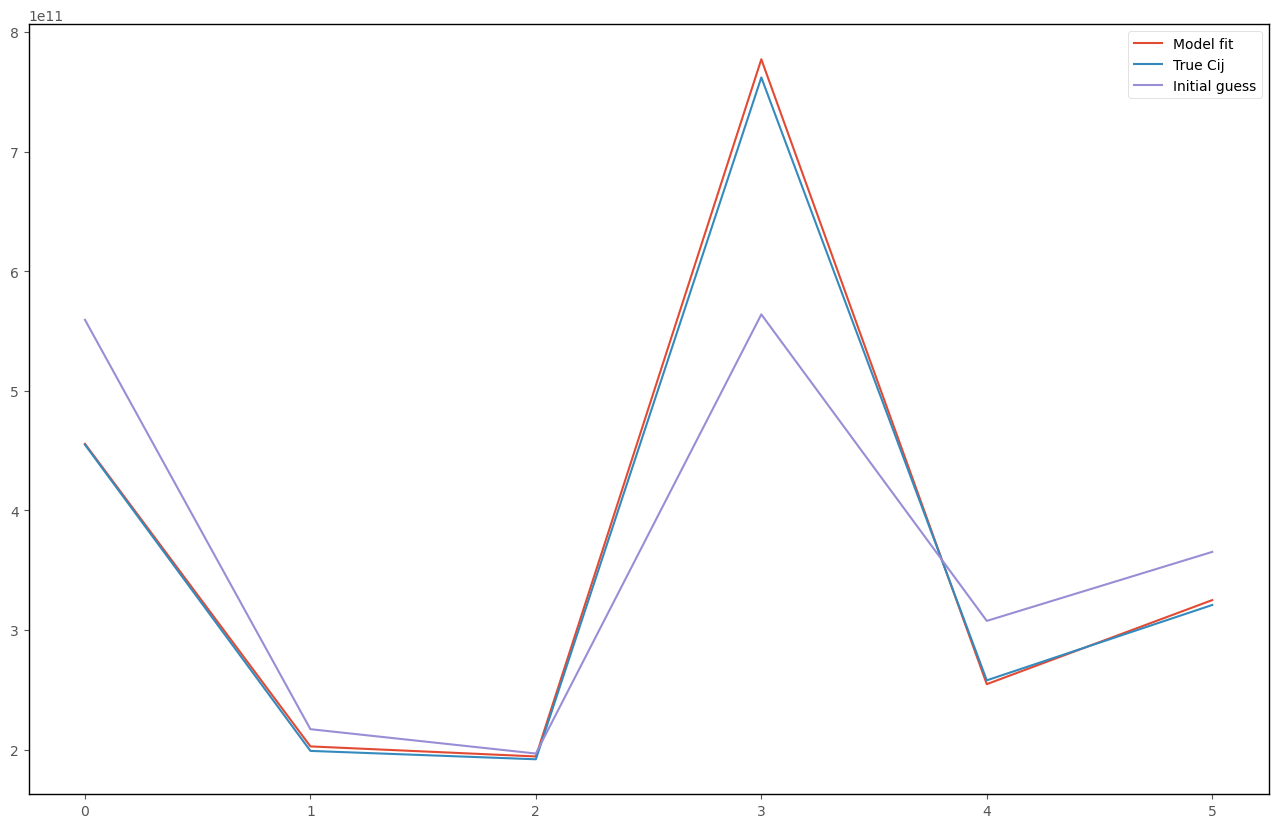

In [66]:
plt.figure()
plt.plot(Cij_fit, label= "Model fit")
plt.plot(stishovite_stiffness, label = "True Cij")
plt.plot(Cij_0, label = "Initial guess")
plt.legend()
plt.show()